In this tutorial, you will learn how to use Python's geopandas package to create spatial grids, map the OD data of taxis in to grids and draw gis maps all using python

<div class="alert alert-info"><h2>The data provided：</h2><p>
    GIS shapefile：<br>
    1.Administrative division of Shenzhen<br>
    <br>
    Data：<br>
    1.Taxi OD data<br></p></div>

[document of geopandas package](http://geopandas.org/index.html)

# Read shp file

[What is shapefile(shp)](https://en.wikipedia.org/wiki/Shapefile)

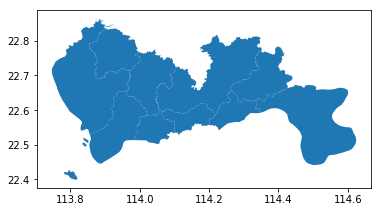

In [3]:
#Import necessary packages
import pandas as pd
import numpy as np

#Package for drawing
import matplotlib as mpl
import matplotlib.pyplot as plt

#geopandas
import geopandas

#shapely
from shapely.geometry import Point,Polygon,shape

#read shapefile
shp = r'shapefile/sz.shp'
sz = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')

#Let's plot to see what it looks like
sz.plot()

Note: Sometimes when you use sz.plot() it only show something like  
<matplotlib.axes._subplots.AxesSubplot at 0x187a50303c8>  
and without any figures  
Don't worry, run it again then it will show


In [4]:
type(sz)

geopandas.geodataframe.GeoDataFrame

The format of **GeoDataFrame** is a datatable similar to pandas DataFrame, but with a column of geometry store the gis information of each row

In [5]:
sz.head(5)

,centroid_x,centroid_y,qh,geometry
0,114.143157,22.577605,罗湖,"POLYGON ((114.1000602929242 22.53430897679428,..."
1,114.041535,22.546180,福田,"POLYGON ((113.9857776734216 22.51347874380918,..."
2,114.270206,22.596432,盐田,"POLYGON ((114.2277234382435 22.54290309518655,..."
3,113.851387,22.679120,宝安,(POLYGON ((113.8183120835192 22.54676277098278...
4,113.926290,22.766157,光明,"POLYGON ((113.9858717771833 22.80304400420075,..."


The gis information in every row of geometry column is the **POLYGON** in shapely package, let's get one out to see what it looks like

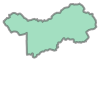

In [6]:
# geometry of the first row
sz['geometry'].iloc[0]

In [7]:
type(sz['geometry'].iloc[0])

shapely.geometry.polygon.Polygon

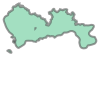

In [8]:
#With the method unary_union, all records of a geopandas can be merged into a single Polygon
sz.unary_union

# Generate spatial grids

Here, I want to use a method that can generate spatial grids shapefile, and also can easily calculate the corresponding grid number from longitude and latitude of the GPS data

Principle of Gridding
<img src="resource/grid_en.png" style="width:500px">


In [10]:
#Code for gridding
import math
#Define a test lon and lat
testlon = 114
testlat = 22.5

#Define the scope
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#Define the size of grid(m)
accuracy = 500;

#Calculate the length of latitude and longitude of the grids: ▲Lon and ▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

#Calculate the loncol and latcol number of the grid
LONCOL=divmod(float(testlon) - (lonStart - deltaLon / 2) , deltaLon)[0]
LATCOL=divmod(float(testlat) - (latStart - deltaLat / 2) , deltaLat)[0]

#Calculate the coordinate of the grid center
HBLON = LONCOL*deltaLon + (lonStart - deltaLon / 2)
HBLAT = LATCOL*deltaLat + (latStart - deltaLat / 2)

#print the result
LONCOL,LATCOL,HBLON,HBLAT,deltaLon,deltaLat

(51.0,
 12.0,
 113.99800701150498,
 22.499547959873865,
 0.004872614089207591,
 0.004496605206422906)

generate spatial grids GeoDataFrame

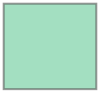

In [11]:
from shapely.geometry import Point,Polygon,shape
Polygon([(HBLON+deltaLon/2,HBLAT-deltaLat/2),
        (HBLON+deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT+deltaLat/2),
        (HBLON-deltaLon/2,HBLAT-deltaLat/2)])

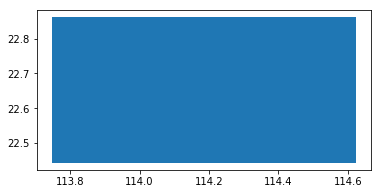

In [15]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point,Polygon,shape


#define an empty GeoDataFrame
data = geopandas.GeoDataFrame()

#define empty lists，It's going to add something into it in every iteration
LONCOL = []
LATCOL = []
geometry = []
HBLON1 = []
HBLAT1 = []

#Calculate how many grids to generate in total
#lonsnum grids for lon direstion
lonsnum = int((lon2-lon1)/deltaLon)+1
#latsnum grids for lat direstion
latsnum = int((lat2-lat1)/deltaLat)+1

for i in range(lonsnum):
    for j in range(latsnum):

        HBLON = i*deltaLon + (lonStart - deltaLon / 2)
        HBLAT = j*deltaLat + (latStart - deltaLat / 2)
        #add things into lists
        LONCOL.append(i)
        LATCOL.append(j)
        HBLON1.append(HBLON)
        HBLAT1.append(HBLAT)
        
        #Generate grid Polygon
        #Here we use the surrounding grids to calculate the position of the three vertices of the grid
        #otherwise the generated grid will have small cracks due to the problem of decimal value and cannot be covered perfectly
        HBLON_1 = (i+1)*deltaLon + (lonStart - deltaLon / 2)
        HBLAT_1 = (j+1)*deltaLat + (latStart - deltaLat / 2)
        
        #Add grid Polygon into list
        geometry.append(Polygon([
        (HBLON-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT-deltaLat/2),
        (HBLON_1-deltaLon/2,HBLAT_1-deltaLat/2),
        (HBLON-deltaLon/2,HBLAT_1-deltaLat/2)]))
        
#Assign lists as the columns of the GeoDataFrame
data['LONCOL'] = LONCOL
data['LATCOL'] = LATCOL
data['HBLON'] = HBLON1
data['HBLAT'] = HBLAT1
data['geometry'] = geometry

data.plot()


Note: if seaborn (another drawing package) is opened, even if the data is the same, the drawing may be different. I suggest not to use seaborn here.

In [16]:
data.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry
0,0,0,113.749504,22.445589,"POLYGON ((113.7470673859108 22.44334039479358,..."
1,0,1,113.749504,22.450085,"POLYGON ((113.7470673859108 22.447837, 113.751..."
2,0,2,113.749504,22.454582,"POLYGON ((113.7470673859108 22.45233360520643,..."
3,0,3,113.749504,22.459079,"POLYGON ((113.7470673859108 22.45683021041285,..."
4,0,4,113.749504,22.463575,"POLYGON ((113.7470673859108 22.46132681561927,..."


obtain the intersection of the grids generated and Shenzhen administrative division:

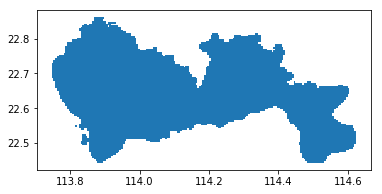

In [17]:
grid = data[data.intersects(sz.unary_union)]
grid.plot()

In [23]:
#save grids
grid.to_file(r'shapefile\grid',encoding = 'utf-8')

# Map GPS data to grid

Tip: we have gridded testlon and testlat in the previous step, so how to grid all OD data of taxis? (please do not use loop, the efficiency is very low)

>In the last tutorial, we have extracted od from the original GPS data of taxis and saved it in  
data-sample/TaxiOD.csv
    

In [13]:
import pandas as pd
TaxiOD = pd.read_csv(r'data-sample/TaxiOD.csv')
TaxiOD.columns = ['VehicleNum', 'Stime', 'SLng', 'SLat', 
       'ELng', 'ELat','Etime']
TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17


In [15]:

###########################You need to write code here#############################
#Calculate the Loncol and Latcol of the starting point
#TaxiOD['SLONCOL'] = 
#TaxiOD['SLATCOL'] = 

#Calculate the Hblon and Hblat of the starting point
#TaxiOD['SHBLON'] = 
#TaxiOD['SHBLAT'] = 

#Calculate the Loncol and Latcol of the ending point
#TaxiOD['ELONCOL'] = 
#TaxiOD['ELATCOL'] = 

#Calculate the Hblon and Hblat of the ending point
#TaxiOD['EHBLON'] = 
#TaxiOD['EHBLAT'] = 

#Filter out od with start and end points in the same grid
#Filter out the grids that are not in the research scope


###################################################################################

TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17


In [18]:
###############################     Answer    ##################################

TaxiOD = TaxiOD[-TaxiOD['ELng'].isnull()].copy()
TaxiOD['SLONCOL'] = ((TaxiOD['SLng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['SLATCOL'] = ((TaxiOD['SLat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['SHBLON'] = TaxiOD['SLONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['SHBLAT'] = TaxiOD['SLATCOL']*deltaLat + (latStart - deltaLat / 2)
TaxiOD['ELONCOL'] = ((TaxiOD['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
TaxiOD['ELATCOL'] = ((TaxiOD['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
TaxiOD['EHBLON'] = TaxiOD['ELONCOL']*deltaLon + (lonStart - deltaLon / 2)
TaxiOD['EHBLAT'] = TaxiOD['ELATCOL']*deltaLat + (latStart - deltaLat / 2)
#Filter out od with start and end points in the same grid
TaxiOD = TaxiOD[-((TaxiOD['SLONCOL']==TaxiOD['ELONCOL'])&(TaxiOD['SLATCOL']==TaxiOD['ELATCOL']))]
#Filter out the grids that are not in the research scope
TaxiOD = TaxiOD[(TaxiOD['SLONCOL']>=0) & (TaxiOD['SLATCOL']>=0) &(TaxiOD['ELONCOL']>=0) & (TaxiOD['ELATCOL']>=0)&
(TaxiOD['SLONCOL']<=lonsnum) & (TaxiOD['SLATCOL']<=latsnum) &(TaxiOD['ELONCOL']<=lonsnum) & (TaxiOD['ELATCOL']<=latsnum)]
###################################################################################
TaxiOD.head(5)

,VehicleNum,Stime,SLng,SLat,ELng,ELat,Etime,SLONCOL,SLATCOL,SHBLON,SHBLAT,ELONCOL,ELATCOL,EHBLON,EHBLAT
0,22223,00:03:23,114.167465,22.562468,114.225235,22.552750,00:10:48,85,25,114.163676,22.558004,97,23,114.222147,22.549011
1,22223,00:11:33,114.227150,22.554167,114.229218,22.560217,00:15:19,98,24,114.227020,22.553507,98,25,114.227020,22.558004
2,22223,00:17:13,114.231354,22.562166,114.255798,22.590967,00:29:06,98,25,114.227020,22.558004,103,32,114.251383,22.589480
3,22223,00:36:45,114.240196,22.563650,114.119965,22.566668,00:54:42,100,26,114.236765,22.562500,76,26,114.119822,22.562500
4,22223,01:01:14,114.135414,22.575933,114.166748,22.608267,01:08:17,79,28,114.134440,22.571494,85,36,114.163676,22.607466


# Aggregate grid OD (All day, Peak hours)

Note：here we need to use the method **df.groupby** from pandas DataFrame, if you don't know that, please <a href="http://pandas.pydata.org/pandas-docs/stable/">check pandas document</a>

In [24]:
#Aggregate grid OD
###########################You need to write code here#############################
#Tips：use df.groupby().count()
#after groupby, columns will become index
#so we use df.reset_index(), to change index into columns

###################################################################################

#sort OD accroding to VehicleNum
OD = OD.sort_values(by = 'VehicleNum',ascending = False)

In [19]:
###############################     Answer    ##################################

#If we don't specify a column, it will count every column, 
#so here I only take one column to aggregate. For example['VehicleNum']
OD= TaxiOD.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['VehicleNum'].count().reset_index()

###################################################################################
#sort OD accroding to VehicleNum
OD = OD.sort_values(by = 'VehicleNum',ascending = False)

# Plot the OD

## plot the top 20 OD

In [25]:
#Take the top 20 OD
Topod = OD.iloc[:20].copy()

#Calculate the longitude and latitude of the starting grid center
Topod['SHBLON'] = Topod['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['SHBLAT'] = Topod['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)

#Calculate the longitude and latitude of the ending grid center
Topod['EHBLON'] = Topod['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
Topod['EHBLAT'] = Topod['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

In [26]:
#Import drawing package
import matplotlib as mpl
import matplotlib.pyplot as plt

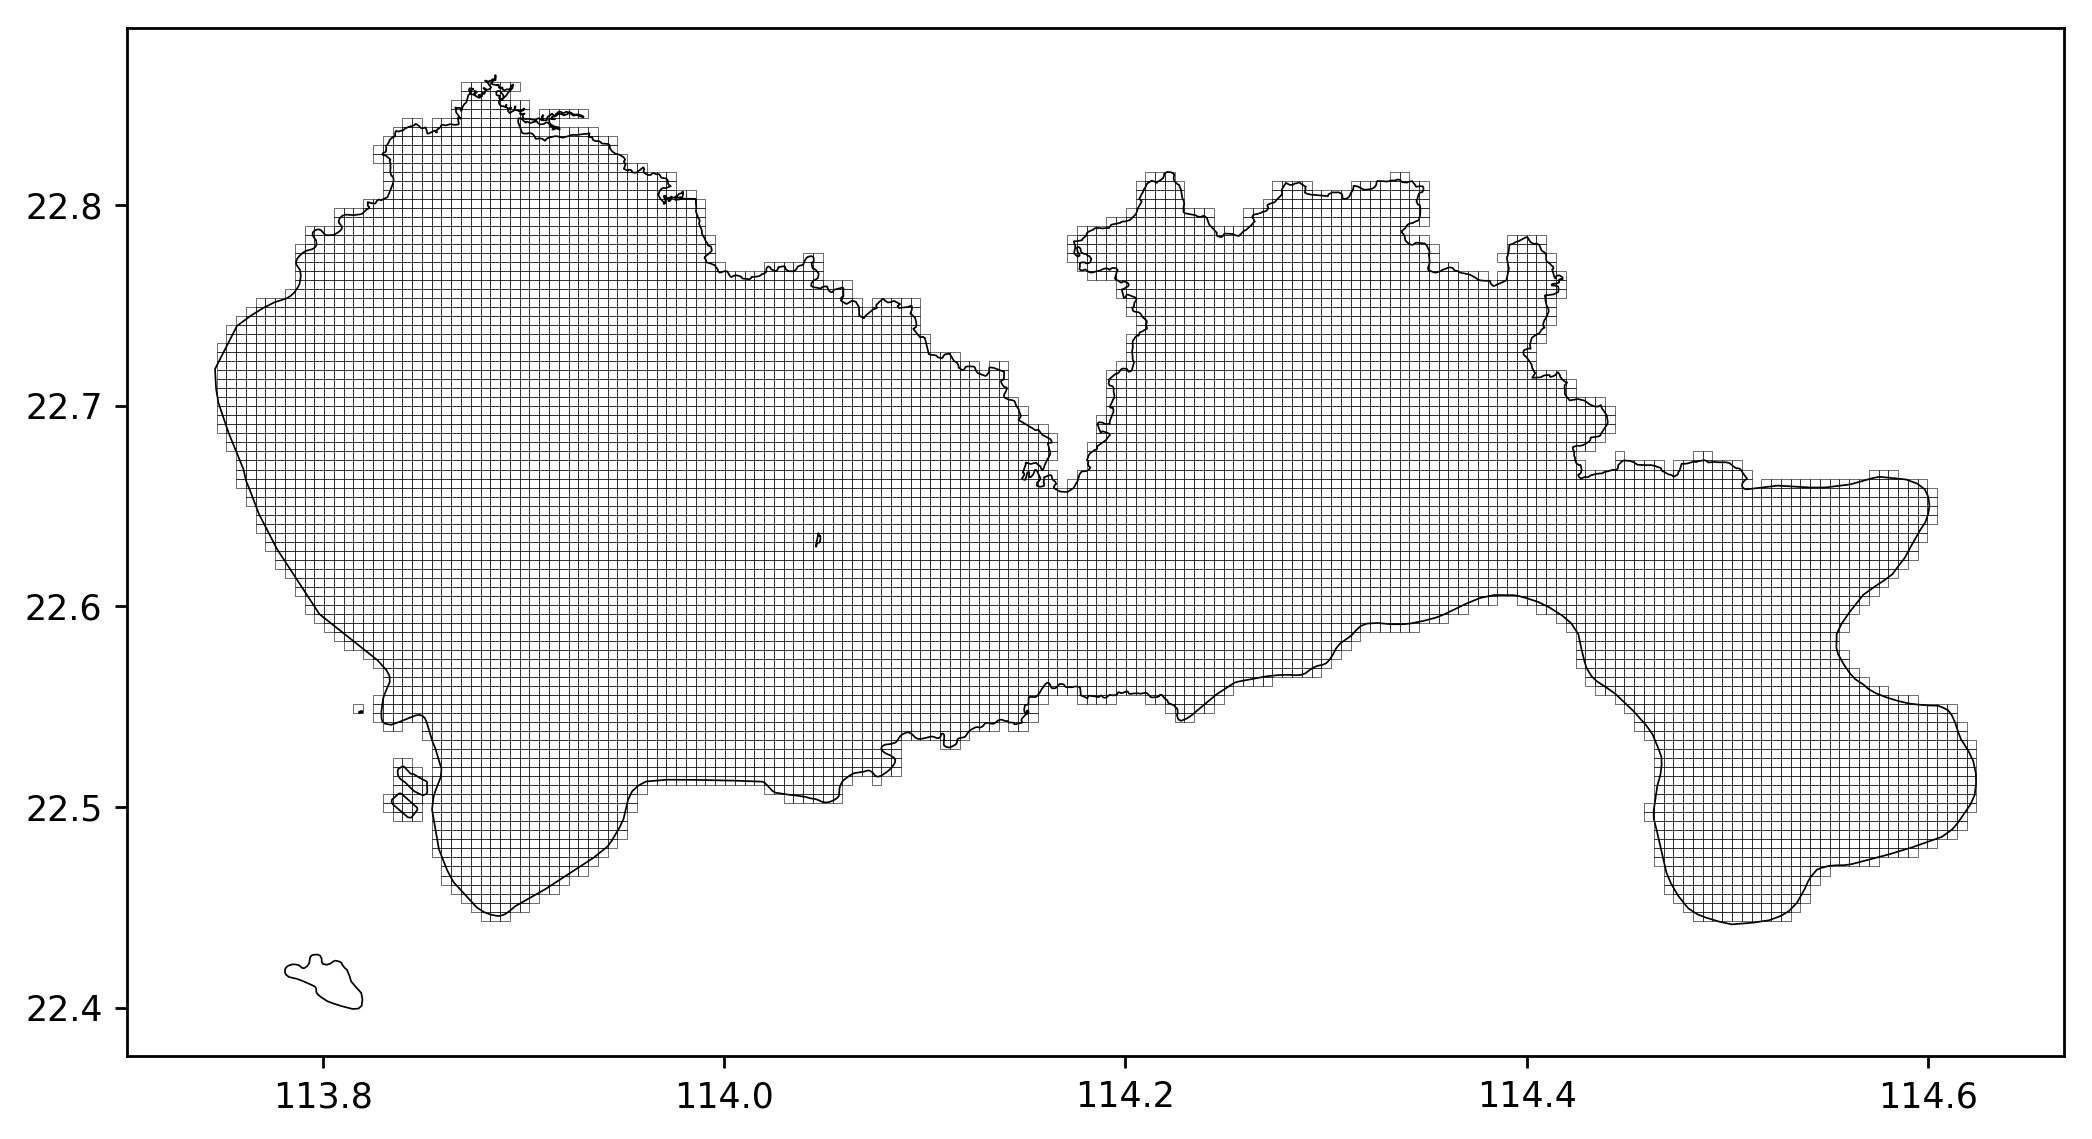

In [22]:
#generate figure
fig     = plt.figure(1,(10,8),dpi = 250)    
#add a subplot
ax      = plt.subplot(111)
#tell python we are going to plot in this subplot
plt.sca(ax)

#plot the grids on the ax
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)

#Transform the merged administrative division into a geodataframe, and draw it on ax
SZ_all = geopandas.GeoDataFrame()
SZ_all['geometry'] = [sz.unary_union]
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

plt.show()

In [ ]:
#Let's plot OD
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)



for i in range(len(Topod)):
###########################You need to write code here#############################
    #First obtain the longitude and latitude of OD
    #And use plt.plot to plot OD
    

##################################################################################
#不显示坐标轴
plt.axis('off')

plt.show()

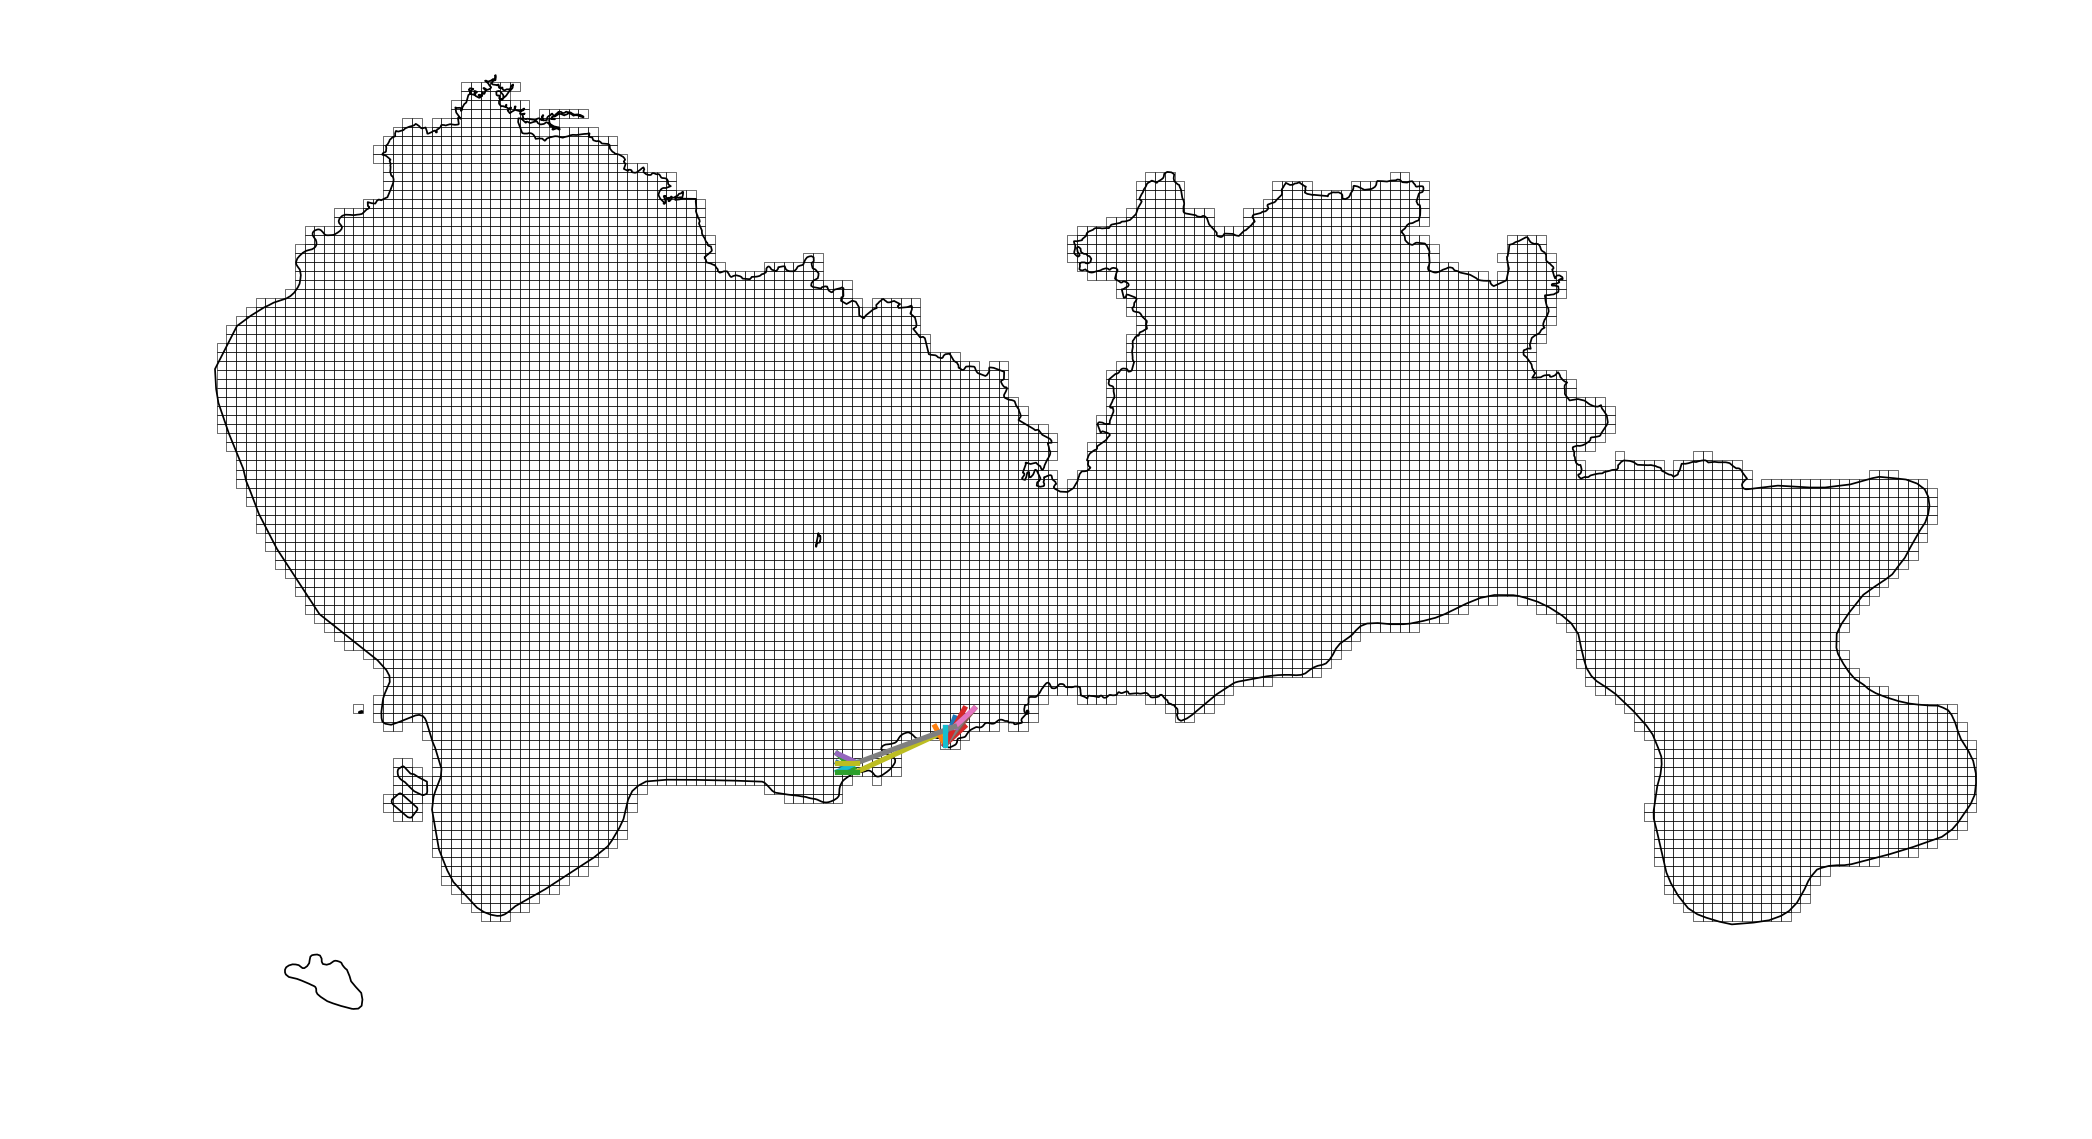

In [27]:
###############################     Answer   ##################################
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

grid.plot(ax =ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

for i in range(len(Topod)):

    
    plt.plot([Topod['SHBLON'].iloc[i],Topod['EHBLON'].iloc[i]],[Topod['SHBLAT'].iloc[i],Topod['EHBLAT'].iloc[i]])


#don't show axis
plt.axis('off')

plt.show()
##################################################################################

## Plot all the OD

Let's plot more OD. At this time, we use the linewidth, color and transparency of OD to display the volume of OD

In [28]:
OD1 = OD[OD['VehicleNum']>10].copy()

#Here we sort the OD from small to large
#because we want to plot small OD first so that it will be in the bottom
OD1 = OD1.sort_values(by = 'VehicleNum')

OD1['SHBLON'] = OD1['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['SHBLAT'] = OD1['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)
OD1['EHBLON'] = OD1['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
OD1['EHBLAT'] = OD1['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

#Divided OD into five groups, and generate a column with a value of 0-1 
#The values of each group are the same, which is used to represent the linewidth of OD
#named linewidth

step = 5
OD1['linewidth'] = (np.array(range(len(OD1)))*step/len(OD1)).astype('int')/step+0.1
OD1.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,SHBLON,SHBLAT,EHBLON,EHBLAT,linewidth
41465,37,17,34,21,11,113.929790,22.522031,113.915173,22.540017,0.1
93970,59,27,61,20,11,114.036988,22.566997,114.046733,22.535521,0.1
149728,74,20,76,27,11,114.110077,22.535521,114.119822,22.566997,0.1
38433,36,18,37,18,11,113.924918,22.526528,113.929790,22.526528,0.1
138355,71,23,68,23,11,114.095459,22.549011,114.080841,22.549011,0.1


绘制OD用时 31.63205885887146 秒


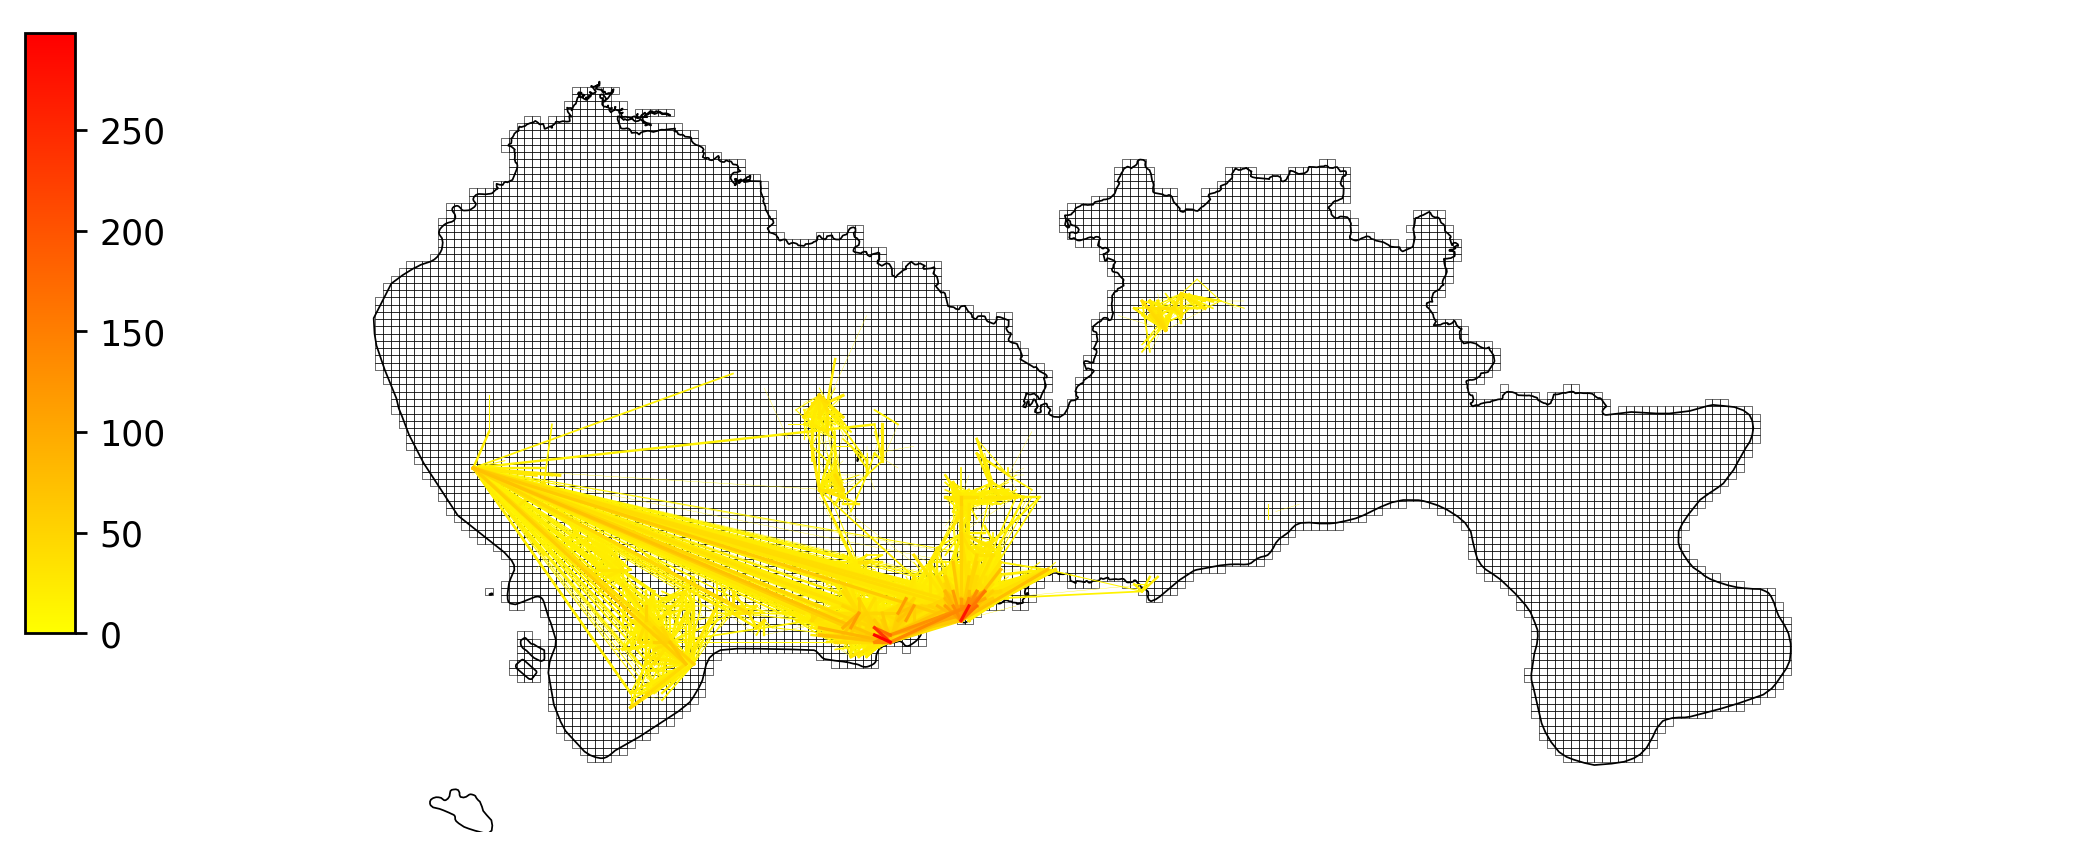

In [37]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)
grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)

#set the colormap
import matplotlib
vmax = OD['VehicleNum'].max()
#Generate a normalized tool by setting the maximum and minimum value of OD. 
#Its function is to  normalize count into the range of 0-1
#by this code: norm(count)

norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
#set the color of colormap
cmapname = 'autumn_r'
#cmap is a tool to get color using cmap(a), which a is a value in 0-1
cmap = matplotlib.cm.get_cmap(cmapname)

#plot OD
import time
timeflag = time.time()
for i in range(len(OD1)):
    ###########################You need to write code here#############################
    #set the alpha and color and linewidth in plt.plot 
    
    
    ###################################################################################

print('time use:',time.time()-timeflag,'s')
    

plt.axis('off')    

#here we want a colorbar for the OD plot, but want we have plotted are lines
#lines don't have colorbar, so we have to think in another way
#plt.imshow is a thing that with a colorbar
#so here, I plot a imshow in a place that we can't see and then add the colorbar

plt.imshow([[0,vmax]], cmap=cmap)
#set the size and the location of colorbar
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

#and we have to set the figure back to shenzhen, otherwise it will show the imshow

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)



plt.show()

## A faster way to plot OD

If we use the way above to plot OD, the rendering speed is a little bit slow, it takes 31s to draw 5319 OD.
However, if the DataFrame is changed into a GeoDataFrame and then drawn with its own plot function, it will be much faster

In [30]:
#generate geometry
###########################You need to write code here#############################
#changed into a GeoDataFrame
#generate geometry for each row


###################################################################################

OD1.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,VehicleNum,SHBLON,SHBLAT,EHBLON,EHBLAT,linewidth,geometry
41465,37,17,34,21,11,113.929790,22.522031,113.915173,22.540017,0.1,LINESTRING (113.9297904142561 22.5220309859059...
93970,59,27,61,20,11,114.036988,22.566997,114.046733,22.535521,0.1,LINESTRING (114.0369879242186 22.5669970379702...
149728,74,20,76,27,11,114.110077,22.535521,114.119822,22.566997,0.1,LINESTRING (114.1100771355568 22.5355208015252...
38433,36,18,37,18,11,113.924918,22.526528,113.929790,22.526528,0.1,LINESTRING (113.9249178001669 22.5265275911124...
138355,71,23,68,23,11,114.095459,22.549011,114.080841,22.549011,0.1,LINESTRING (114.0954592932891 22.5490106171445...


In [ ]:
#generate geometry
###############################     Answer   ##################################

from shapely.geometry import LineString
OD1['geometry'] = OD1.apply(lambda r:LineString([[r['SHBLON'],r['SHBLAT']],[r['EHBLON'],r['EHBLAT']]]),axis = 1)
OD1 = geopandas.GeoDataFrame(OD1)
###################################################################################

OD1.head(5)

1.7782769203186035 s to plot the grids and shenzhen shape
 0.23633337020874023 s to plot OD


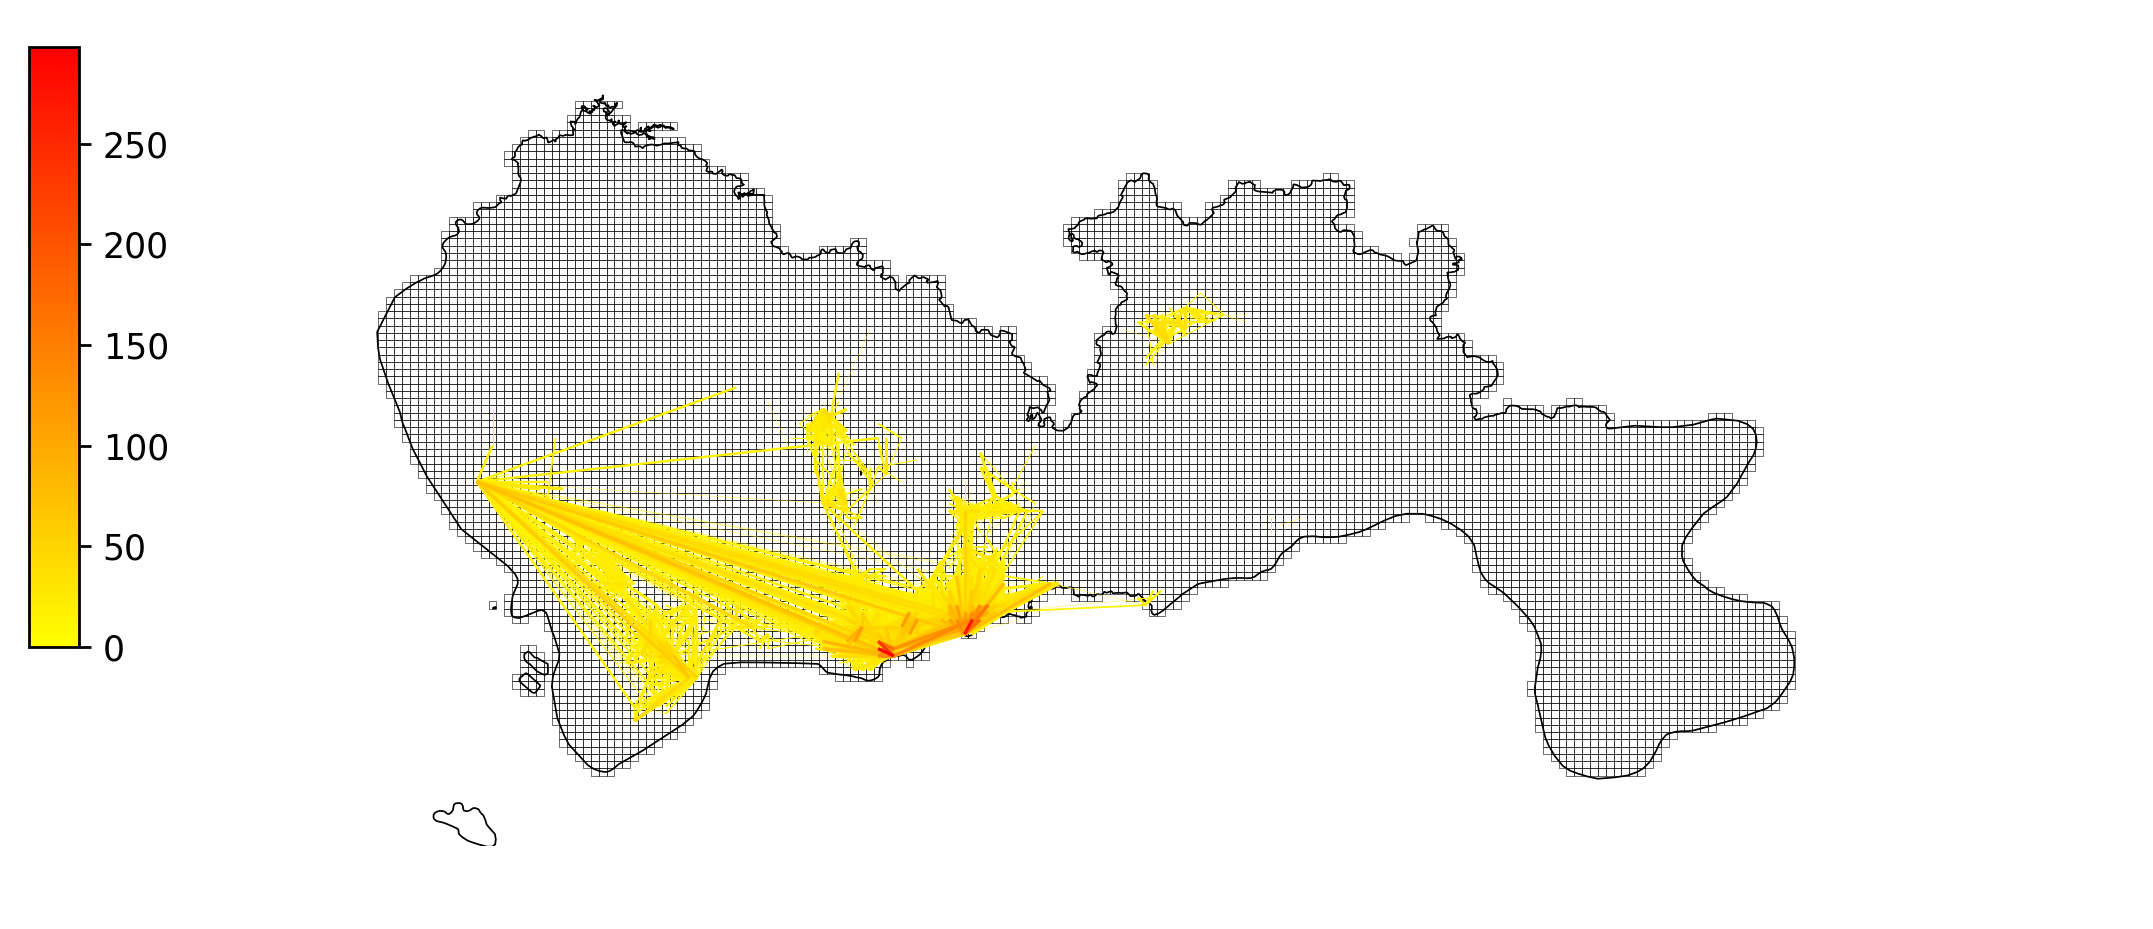

In [32]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)

#time it
import time
timeflag = time.time()

grid.plot(ax = ax,edgecolor = (0,0,0,0.8),facecolor = (0,0,0,0),linewidths=0.2)
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)
print(time.time()-timeflag,'s to plot the grids and shenzhen shape')


#set colormap
import matplotlib
vmax = OD['VehicleNum'].max()
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)

timeflag = time.time()
#plot OD
OD1.plot(ax = ax,column = 'VehicleNum',vmax = vmax,vmin = 0,cmap = cmap,linewidth = OD1['linewidth'])
print('',time.time()-timeflag,'s to plot OD')

plt.axis('off')    
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)
plt.show()

GeoDataFrame only need 0.23s！

# Plot the grid plot

Plot the distribution of start points

In [33]:
#Aggregate
Odistribution = OD.groupby(['SLONCOL','SLATCOL'])['VehicleNum'].sum().reset_index()

In [83]:
#Merge the aggregated result with the GeoDataFrame
gridtoplot = pd.merge(grid,Odistribution.rename(columns = {'SLONCOL':'LONCOL','SLATCOL':'LATCOL'}),on = ['LONCOL','LATCOL'])
gridtoplot = gridtoplot.rename(columns = {'VehicleNum':'count'})

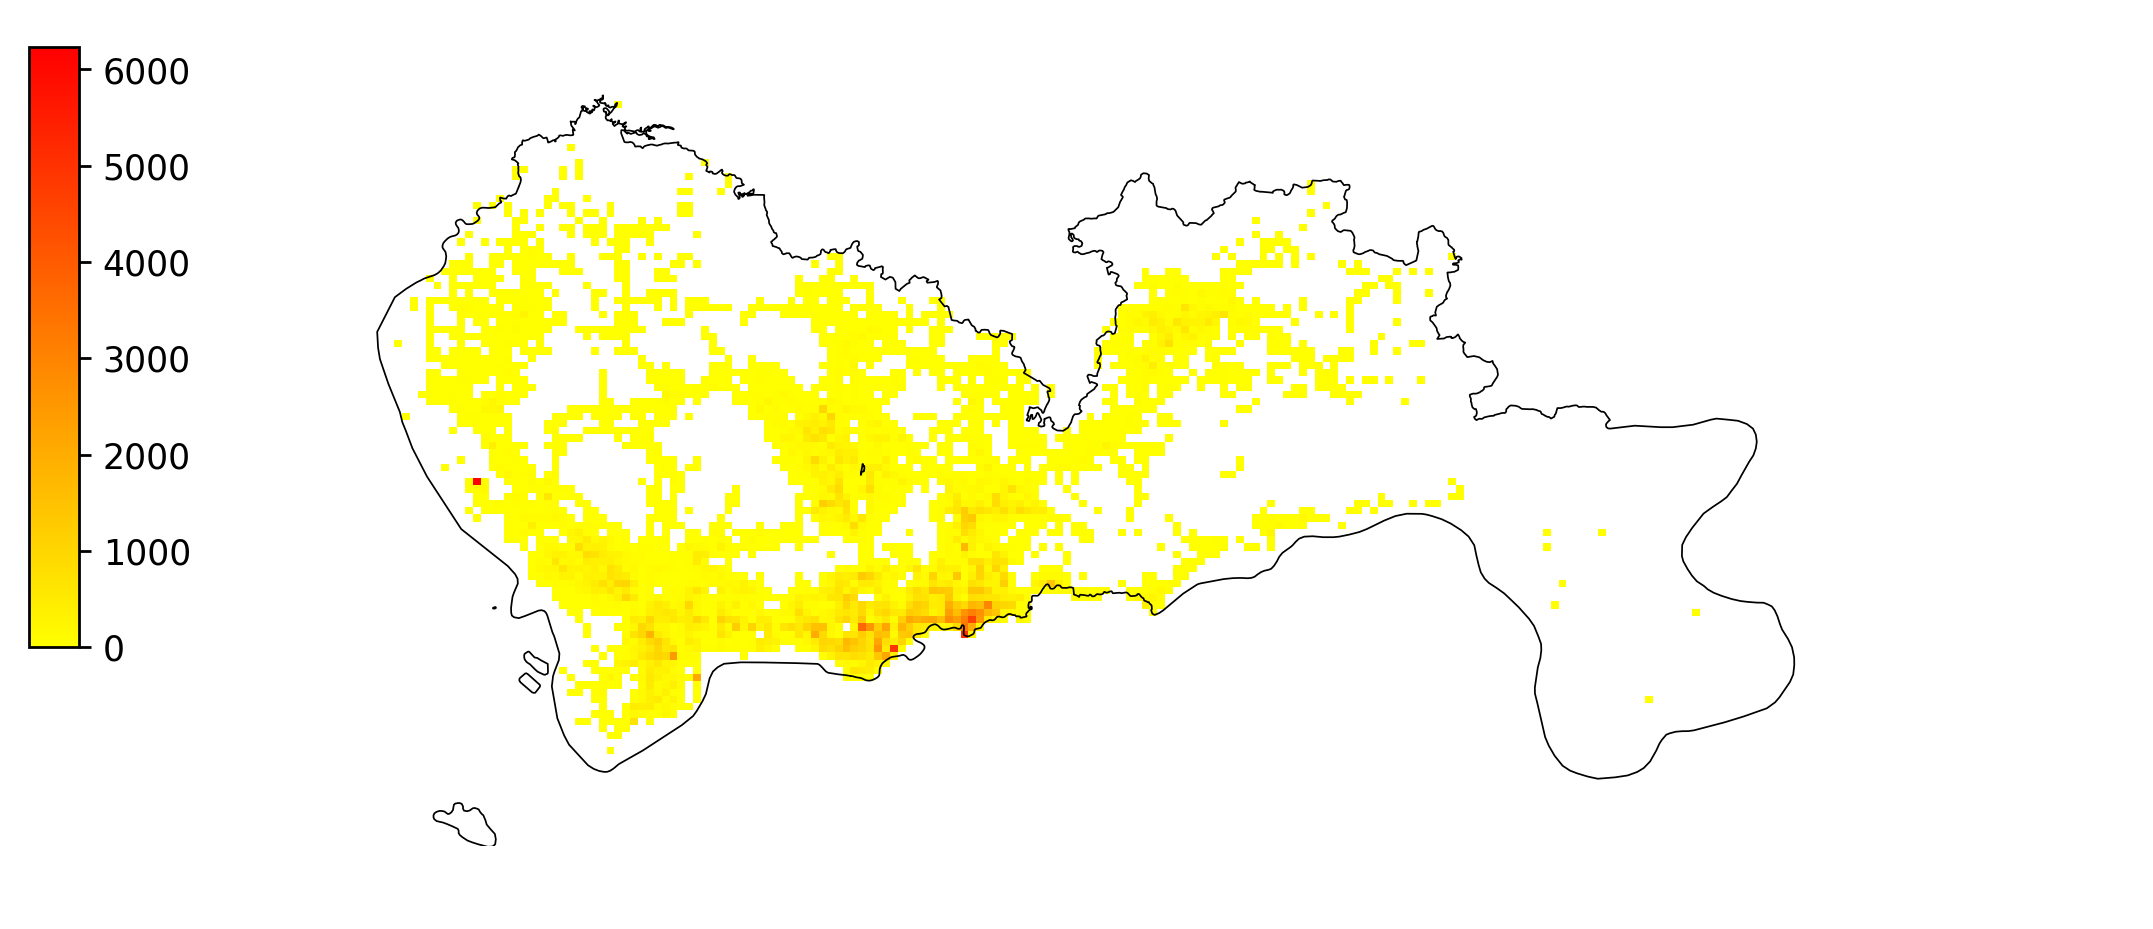

In [90]:
fig     = plt.figure(1,(10,8),dpi = 250)    
ax      = plt.subplot(111)
plt.sca(ax)


import matplotlib
vmax = gridtoplot['count'].max()
norm = mpl.colors.Normalize(vmin=0,vmax=vmax)
cmapname = 'autumn_r'
cmap = matplotlib.cm.get_cmap(cmapname)


#Plot the gridtoplot
#Tip：Use gridtoplot.plot
#Set the parameter column = 'count'，which means that you are going to plot 
#according to the column 'count', and set cmap = cmap, which is its colormap
###########################You need to write code here#############################
#gridtoplot.plot(...)


###################################################################################

#plot the shape of Shenzhen
SZ_all.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0),linewidths=0.5)



plt.axis('off')    

#plot the fake colorbar
plt.imshow([[0,vmax]], cmap=cmap)
cax = plt.axes([0.08, 0.4, 0.02, 0.3])
plt.colorbar(cax=cax)

ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()

# Homework

In the tutorial above. We learn about how to plot OD.
But when our teacher ask us to plot 800 figures, how can we iteratively generate figures?
Here, let's try to write a for loop to plot the OD flow in every hour and save them as .png file. 


(Tip: use **plt.title()** to set the name of the figure, and use **plt.savefig(path)** to save the figure. remember to clear the drawing board after finish each plot.)

# One more thing: Plot the road network

Although the picture above is perfect, even Xiao Xu,who is very familiar with Shenzhen map, can't recognize where the red place is and where the yellow place is.



So it is better to add the road network to the map as the background

OpenStreetMap（OSM） is an open source map service. We can download the latest map shp file of China from the website below(OSM in Japan don't have shapefile on this website, but only with the .osm.pbf file, which can transfer into shp by some tool):

<a href="http://download.geofabrik.de/asia.html">http://download.geofabrik.de/asia.html</a>

## Let's extract and plot the road network  using geopandas

Well, after the training above, map processing should not be difficult. Now our goal is:

>1.Download the map shp  
    2.Read by geopandas  
    3.Filter out the road network of Shenzhen  
    4.Add one more layer on the top of the map, with light colour  

Tip：Using the method **geodataframe.to_file(path,encoding = 'utf-8')**, you can export it into a shp file.